# 形态学分割

## 实验目的

试利用数学形态学的方法去除下图噪声并计数。

![example](example.png)

## 实验环境
- SciPy
- NumPy
- OpenCV
- MatPlotLib

## 实验方法：数学形态学（二值图像）

数学形态学是一种基于集合论的图像处理方法，主要用于处理二值图像和灰度图像。在二值图像中，像素值通常为0和1，分别表示背景和前景。

### 膨胀

膨胀操作的目的是将前景区域扩展，使其变大。定义如下：

$$ A \oplus B = \{ z \mid (B_z \cap A) \neq \emptyset \} $$

其中，$A$ 表示二值图像，$B$ 表示结构元素，$B_z$ 表示结构元素在$z$点的平移。

膨胀操作会使结构元素$B$与图像$A$中的前景部分重叠，只要结构元素中有任何一个像素与$A$的前景像素重叠，那么该像素位置就会被设置为1。

在Python中可以使用`cv2.dilate`函数进行膨胀操作。

### 腐蚀

腐蚀操作的目的是缩小前景区域，使其变小。其定义如下：

$$ A \ominus B = \{ z \mid B_z \subseteq A \} $$

同样，$A$ 表示二值图像，$B$ 表示结构元素，$B_z$ 表示结构元素在$z$点的平移。

腐蚀操作会使结构元素$B$与图像$A$的前景部分进行“包含测试”，只有当结构元素$B$的所有像素都位于$A$的前景像素上时，中心像素才会保留为1，否则被腐蚀为0。

在Python中，可以使用`cv2.erode`函数进行腐蚀操作。

### 开运算

开运算是腐蚀操作后紧跟膨胀操作的过程，常用于消除图像中的小型噪声。其数学表达式为：

$$ A \circ B = (A \ominus B) \oplus B $$

开运算首先对图像进行腐蚀操作以移除噪声点，然后进行膨胀操作以恢复剩余前景区域的大小。

在Python中可以使用`cv2.morphologyEx`函数传入`cv2.MORPH_OPEN`实现开运算：

### 闭运算

闭运算是膨胀操作后紧跟腐蚀操作的过程，常用于填补前景对象内部的小孔。其数学表达式为：

$$ A \bullet B = (A \oplus B) \ominus B $$

闭运算首先对图像进行膨胀操作以填充前景内部的孔洞，然后进行腐蚀操作以恢复前景物体的形状。

在Python中也可以通过`cv2.morphologyEx`函数传入`cv2.MORPH_CLOSE`实现闭运算。

## 实验步骤

### 二值化
由于我们学的形态学操作都是针对二值图像的，先进行图像的二值化（这里利用预置的Otsu's 阈值分割），这也是符合最终的计数任务的。

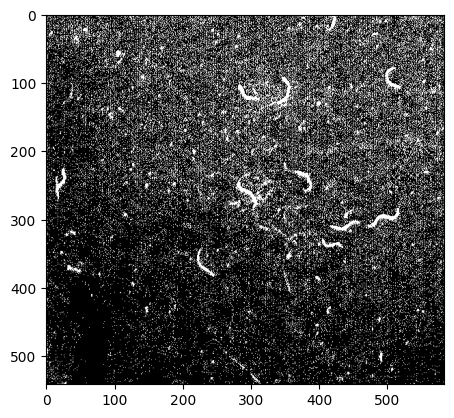

In [99]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('example.png', cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')

## 初步去噪
因为背景的噪点大多数尺寸很小，所以选择较小的kernel进行开运算。

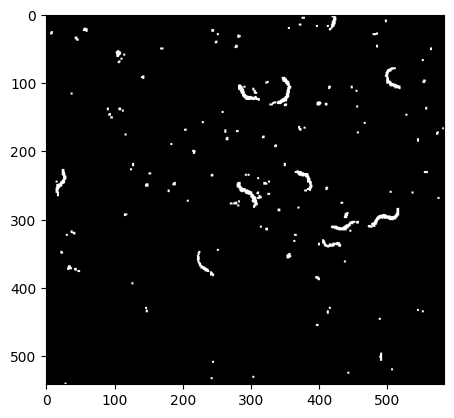

In [100]:
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))
plt.imshow(img, cmap='gray')

### 形态学去噪与分割

观察图像，发现计数对象都是长条形，散落在各个方向，且在一个方向上的延展超过15个像素，这一点与背景的点状噪声是十分不同的，所以这就启发我们设计长条形的结构元素。这些结构元素长度15（对于对角线方向就会短一些），每个都由前一个旋转1度形成。我们可以先用结构元素对图像进行腐蚀，分别过滤出每个方向上长条状延展的模式，然后对每个结果做或运算，得到具有长条状特征的物体。由于目标对象可能弯曲从而在多个方向伸展，所以同一目标可能在不同位置有不同模式被识别，我们还需要将这些特征点连起来，避免重复计数。因为目标物体间的距离大于5像素，我们使用5*5的椭圆结构元素做膨胀操作，将同一目标物体的特征点连起来的同时防止将不同物体的特征点错误连接。

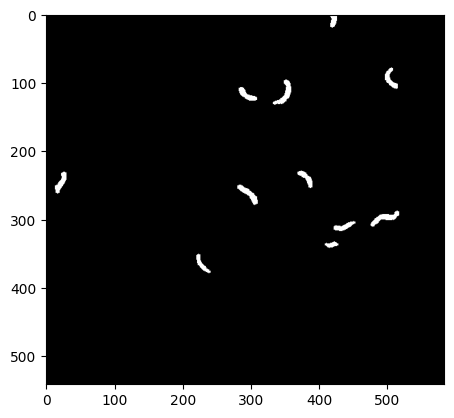

In [102]:
import numpy as np
from scipy.ndimage import rotate

LENGTH = 15
erode_img = np.zeros_like(img)
for theta in range(0, 180, 1):
    kernel = np.eye(LENGTH, dtype=np.uint8)
    kernel = rotate(kernel, theta, reshape=False)
    kernel = cv2.resize(kernel, (LENGTH, LENGTH))
    erode_img |= cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    
# fill the gaps
kernel6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
result_img = cv2.dilate(erode_img, kernel6)

plt.imshow(result_img, cmap='gray')

可以看到这个方法对目标物体的识别效果不错，背景的噪点已经被完全去除。

### 计数
由于现在不同的目标物体已经被二值化地分离，将相邻的白色像素视作连通的，只需要计算非连通子图的个数即可对目标物体计数。

检测到的目标物体数量: 11


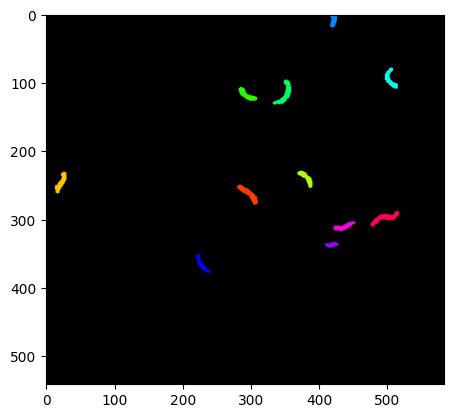

In [103]:
num_labels, labels_im = cv2.connectedComponents(result_img)
print(f"检测到的目标物体数量: {num_labels - 1}")

# color the labels
label_hue = np.uint8(179 * labels_im / np.max(labels_im))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0

plt.imshow(labeled_img)

## 实验总结
本实验利用数学形态学的方法，对含有噪声的二值化图像进行了去噪和目标物体计数。通过设计长条形结构元素对不同方向的长条物体进行过滤，结合形态学运算消除噪声，成功识别了目标物体。最后，利用连通分量分析方法进行物体计数。